In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from scipy.stats import gamma, gaussian_kde
import seaborn as sns
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.dates import DateFormatter

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
colors_plain = ['#333333', '#1F77B4', 'grey']
colors = ['#2878B5', '#9AC9DB', '#F8AC8C', '#C82423', '#FF8884']

In [2]:
def get_coefs(fname, tmin = 20, tmax = 40):
    coefs = pd.read_csv('Data/'+fname)
    coefs.columns = ['x', 'coef', 'se', 't', 'p', 'conf_int_l', 'conf_int_u']
    xs = []
    ls = []
    us = []
    ts = []
    for t in range(tmin, tmax+1):
        try:
            if t < tmax:
                temp = coefs[coefs.x == 'cut_maxtemp(%d,%d]' % (t, t+1)]
            else:
                temp = coefs[coefs.x == 'cut_maxtemp(%d, Inf]' % t]
            xs.append(temp.coef.iloc[0])
            ls.append(temp.conf_int_l.iloc[0])
            us.append(temp.conf_int_u.iloc[0])
            ts.append(t)
        except:
            pass
    return xs, ls, us, ts

# Fig. 4a

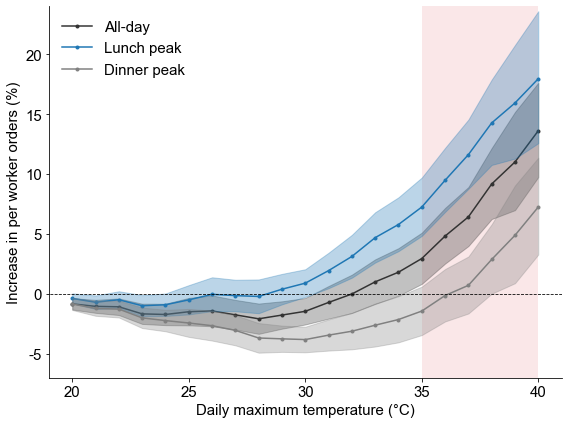

In [3]:
plt.figure(figsize = (8, 6))
plt.hlines(0, 10, 50, color = 'black', ls = '--', lw = 0.8)
xs, ls, us, ts = get_coefs('city_rider_order_avg.csv')
plt.plot(ts, np.exp(xs) - 1, color = colors_plain[0], marker = '.', label = 'All-day', zorder = 1)
plt.fill_between(ts, np.exp(ls) - 1, np.exp(us) - 1, color = colors_plain[0], alpha = 0.3, zorder = 1)
xs, ls, us, ts = get_coefs('city_rider_noon_order_avg.csv')
plt.plot(ts, np.exp(xs) - 1, color = colors_plain[1], marker = '.', label = 'Lunch peak', zorder = 1)
plt.fill_between(ts, np.exp(ls) - 1, np.exp(us) - 1, color = colors_plain[1], alpha = 0.3, zorder = 1)
xs, ls, us, ts = get_coefs('city_rider_evening_order_avg.csv')
plt.plot(ts, np.exp(xs) - 1, color = colors_plain[2], marker = '.', label = 'Dinner peak', zorder = 1)
plt.fill_between(ts, np.exp(ls) - 1, np.exp(us) - 1, color = colors_plain[2], alpha = 0.3, zorder = 1)
plt.xlim(19, 41)
plt.ylim(-0.07, 0.24)
plt.bar(x = [37.5], height = [0.48], width = 5, bottom = [-0.07], color = '#eea2a4', alpha = 0.25, zorder = 0)
plt.yticks([-0.05, 0, 0.05, 0.1, 0.15, 0.2], [-5, 0, 5, 10, 15, 20], size = 15)
plt.xticks([20, 25, 30, 35, 40], size = 15)
celsius_symbol = chr(176)
plt.xlabel('Daily maximum temperature ('+celsius_symbol+'C)', size = 15)
plt.ylabel('Increase in per worker orders (%)', size = 15)
plt.legend(fontsize = 15, frameon = False, loc = 'upper left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Fig.4b

In [4]:
rider_MET = pd.read_csv('Data/rider_experienced_MET.csv')
user_MET = pd.read_csv('Data/user_mitigated_MET.csv')

In [5]:
x = np.array(rider_MET.max_temp).reshape(-1, 1)
y = np.array(rider_MET.per_rider_MET).reshape(-1, 1)
xystack = np.vstack([rider_MET.max_temp, rider_MET.per_rider_MET])
z = gaussian_kde(xystack)(xystack)
idx = z.argsort()
x, y, z = rider_MET.max_temp.iloc[idx], rider_MET.per_rider_MET.iloc[idx], z[idx]

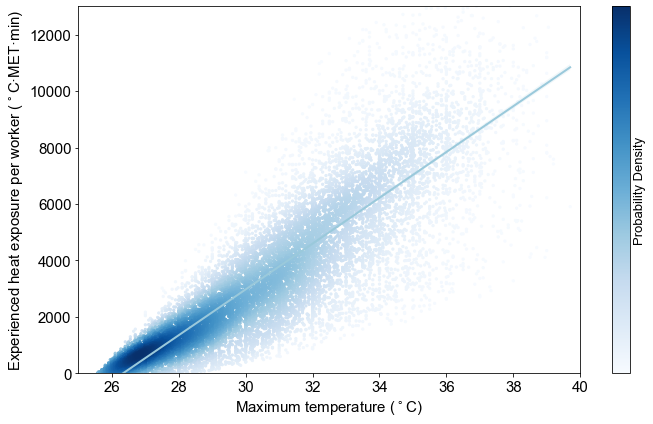

In [6]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(x, y, s = 5, c = z, cmap = 'Blues')
cbar = plt.colorbar(ticks = [])
cbar.set_label(label = r'Probability Density', fontdict = {'size': 13})
sns.regplot(ax = ax, data = rider_MET, x = 'max_temp', y ='per_rider_MET', scatter = False, line_kws = {'lw': 2, 'color': colors[1]})
plt.ylabel('Experienced heat exposure per worker ($^\circ$C·MET·min)', size = 15)
plt.xlabel('Maximum temperature ($^\circ$C)', size = 15)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.xlim(25, 40)
plt.ylim(0, 13000)
plt.tight_layout()
plt.show()

# Fig. 4c

In [7]:
x1 = np.array(user_MET.max_temp).reshape(-1, 1)
y1 = np.array(user_MET.per_order_MET_user).reshape(-1, 1)
xystack = np.vstack([user_MET.max_temp, user_MET.per_order_MET_user])
z1 = gaussian_kde(xystack)(xystack)
idx = z1.argsort()
x1, y1, z1 = user_MET.max_temp.iloc[idx], user_MET.per_order_MET_user.iloc[idx], z1[idx]

x = np.array(rider_MET.max_temp).reshape(-1, 1)
y = np.array(rider_MET.per_order_MET_rider).reshape(-1, 1)
xystack = np.vstack([rider_MET.max_temp, rider_MET.per_order_MET_rider])
z = gaussian_kde(xystack)(xystack)
idx = z.argsort()
x, y, z = rider_MET.max_temp.iloc[idx], rider_MET.per_order_MET_rider.iloc[idx], z[idx]

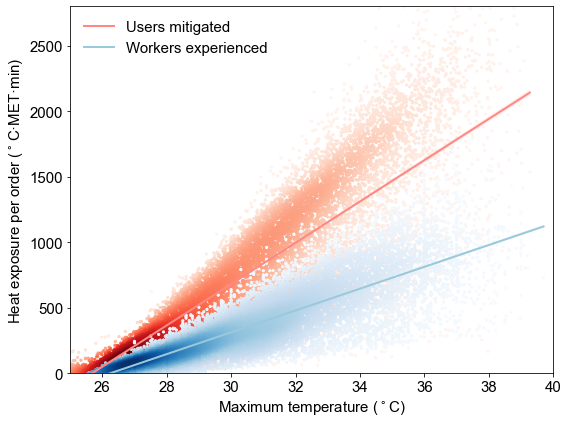

In [8]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(x1, y1, s = 5, c = z1, cmap = 'Reds', alpha = 1, zorder = 0)
plt.scatter(x, y, s = 5, c = z, cmap = 'Blues', alpha = 1, zorder = 0)
sns.regplot(ax = ax, data = user_MET, x = 'max_temp', y ='per_order_MET_user', scatter = False, line_kws = {'lw': 2, 'color': colors[4]}, label = 'Users mitigated')
sns.regplot(ax = ax, data = rider_MET, x = 'max_temp', y ='per_order_MET_rider', scatter = False, line_kws = {'lw': 2, 'color': colors[1]}, label = 'Workers experienced')
plt.ylabel('Heat exposure per order ($^\circ$C·MET·min)', size = 15)
plt.xlabel('Maximum temperature ($^\circ$C)', size = 15)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.xlim(25, 40)
plt.ylim(0, 2800)
plt.legend(fontsize = 15, frameon = False, loc = 'upper left')
plt.tight_layout()
plt.show()

# Fig. 4d

In [9]:
daily_MET = pd.read_csv('Data/per_oder_MET_daily.csv')
daily_MET['dt'] = pd.to_datetime(daily_MET['dt'], format='%Y-%m-%d')
daily_MET = daily_MET.set_index('dt')

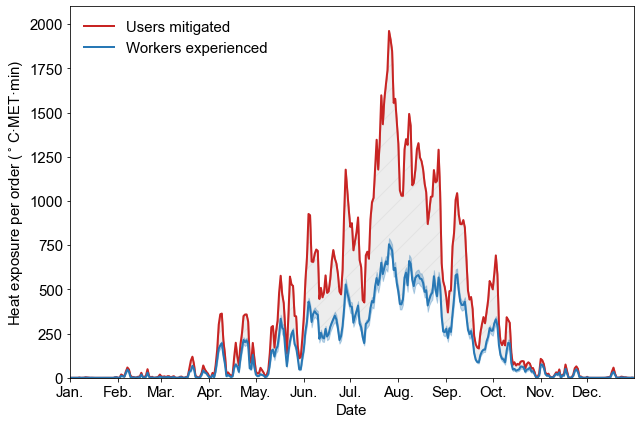

In [10]:
fig, ax = plt.subplots(figsize = (9, 6))
ymax = 2100
ax.plot(daily_MET['avg_MET_user'], color = colors[3], zorder = 1, lw = 2, label = 'Users mitigated')
ax.fill_between(daily_MET.index, daily_MET['avg_MET_user_l'], daily_MET['avg_MET_user_h'], color = colors[3], alpha = 0.3)
ax.plot(daily_MET['avg_MET_rider'], color = colors[0], zorder = 1, lw = 2, label = 'Workers experienced')
ax.fill_between(daily_MET.index, daily_MET['avg_MET_rider_l'], daily_MET['avg_MET_rider_h'], color = colors[0], alpha = 0.3)
ax.fill_between(daily_MET.index, daily_MET['avg_MET_user'], daily_MET['avg_MET_rider'], color = 'lightgrey', alpha = 0.4, hatch = '/', zorder = 0)
ax.set_xlabel('Date', size = 15)
ax.set_ylabel('Heat exposure per order ($^\circ$C·MET·min)', size = 15, color = 'black')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
date_format = DateFormatter("%b.")
ax.xaxis.set_major_formatter(date_format)
ax.set_ylim(0, ymax)
ax.set_xlim(daily_MET.index.min(), daily_MET.index.max())
plt.legend(fontsize = 15, frameon = False, loc = 'upper left')
plt.tight_layout()
plt.show()

# Fig. S7

In [11]:
transfer_rate_monthly = np.array([0.62069358, 0.87823731, 0.6169231 , 0.59977159, 0.53991576,
       0.50586874, 0.43424605, 0.47673509, 0.56613948, 0.5923375 ,
       0.72217741, 0.67176146])

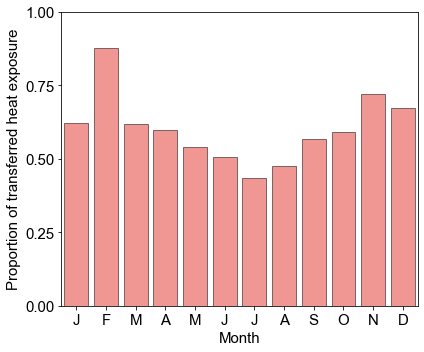

In [12]:
plt.figure(figsize = (6, 5))
sns.barplot(transfer_rate_monthly, color = colors[4], edgecolor='black', linewidth = 0.5)
plt.xticks(range(12), ['J','F','M','A','M','J','J','A','S','O','N','D'], size = 15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size = 15)
celsius_symbol = chr(176)
plt.ylabel('Proportion of transferred heat exposure', size = 15)
plt.xlabel('Month', size = 15)
plt.xlim(-0.5, 11.5)
plt.tight_layout()
plt.show()

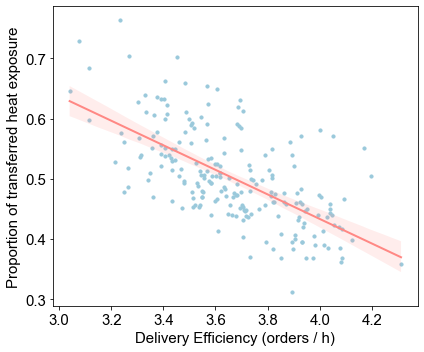

In [13]:
transfer_efficiency = pd.read_csv('Data/MET_transfer_efficiency.csv')
fig, ax = plt.subplots(figsize = (6, 5))
plt.scatter(transfer_efficiency.delivery_efficiency, transfer_efficiency.transfer_rate, color = colors[1], s = 10)
sns.regplot(ax = ax, data = transfer_efficiency, x = 'delivery_efficiency', y ='transfer_rate', scatter = False, line_kws = {'lw': 2, 'color': colors[4]})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylabel('Proportion of transferred heat exposure', size = 15)
plt.xlabel('Delivery Efficiency (orders / h)', size = 15)
plt.tight_layout()
plt.show()

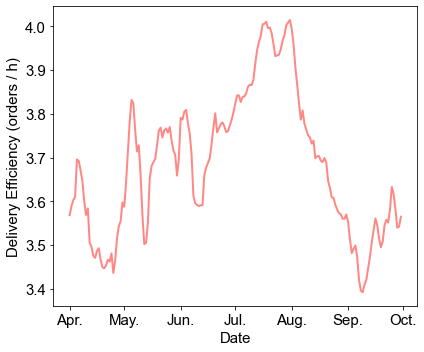

In [14]:
efficiency_df = pd.read_csv('Data/daily_delivery_efficiency.csv')
efficiency_df['dt'] = pd.to_datetime(efficiency_df['dt'], format='%Y-%m-%d')
efficiency_df = efficiency_df.set_index('dt')
fig, ax = plt.subplots(figsize = (6, 5))
ax.plot(efficiency_df['delivery_efficiency'], lw = 2, color = colors[4])
ax.set_xlabel('Date', size = 15)
ax.set_ylabel('Delivery Efficiency (orders / h)', size = 15)
date_format = DateFormatter("%b.")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.show()

# Fig. S8

In [15]:
top100cities = ['北京市', '上海市', '深圳市', '广州市', '成都市', '杭州市', '重庆市', '苏州市', '东莞市', '武汉市', '南京市', '郑州市', '长沙市', '佛山市', '天津市', '西安市', '沈阳市', '宁波市', '昆明市', '合肥市', '无锡市', '长春市', '福州市', '济南市', '青岛市', '金华市', '南宁市', '哈尔滨市', '中山市', '厦门市', '惠州市', '石家庄市', '泉州市', '南昌市', '贵阳市', '大连市', '汕头市', '常州市', '台州市', '海口市', '徐州市', '温州市', '临沂市', '南通市', '太原市', '嘉兴市', '绍兴市', '珠海市', '烟台市', '洛阳市', '呼和浩特市', '保定市', '芜湖市', '江门市', '潍坊市', '廊坊市', '乌鲁木齐市', '吉林市', '兰州市', '唐山市', '扬州市', '济宁市', '湖州市', '盐城市', '湛江市', '淮安市', '赣州市', '镇江市', '漳州市', '绵阳市', '延边朝鲜族自治州', '银川市', '鞍山市', '柳州市', '遵义市', '新乡市', '南阳市', '淄博市', '泰州市', '衡阳市', '商丘市', '威海市', '秦皇岛市', '宿迁市', '常德市', '宜昌市', '包头市', '莆田市', '连云港市', '九江市', '阜阳市', '南充市', '肇庆市', '齐齐哈尔市', '三亚市', '通辽市', '揭阳市', '赤峰市', '沧州市', '株洲市']

In [16]:
t19 = pd.read_csv('Data/climate_allcities.csv')
t19['year'] = t19.dt.apply(lambda x: str(x)[:4])
t19 = t19[t19.year == '2019']
t19['month'] = t19.dt.apply(lambda x: int(str(x)[4:6]))
t50 = pd.read_csv('Data/maxtemp_2035_allcities.csv', encoding = 'gbk')
t99 = pd.read_csv('Data/maxtemp_2050_allcities.csv', encoding = 'gbk')

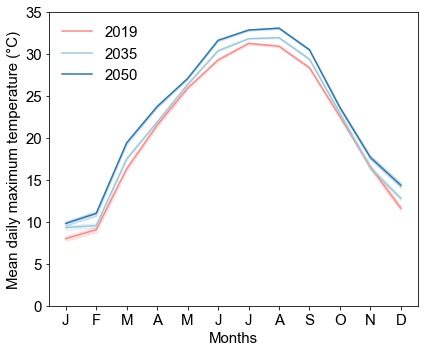

In [17]:
# 加上calibration
t50['model.avg_calibrated'] = t50['model.avg'] + t50['calibration']
t99['model.avg_calibrated'] = t99['model.avg'] + t99['calibration']
plt.figure(figsize = (6, 5))
sns.lineplot(x = 'month', y = 'max_temp', data = t19[t19.city_name.isin(top100cities)], label = '2019', color = colors[4])
sns.lineplot(x = 'month', y = 'model.avg_calibrated', data = t50[t50.city_name.isin(top100cities)], label = '2035', color = colors[1])
sns.lineplot(x = 'month', y = 'model.avg_calibrated', data = t99[t99.city_name.isin(top100cities)], label = '2050', color = colors[0])
celsius_symbol = chr(176)
plt.ylabel('Mean daily maximum temperature ('+celsius_symbol+'C)', size = 15)
plt.xlabel('Months', size = 15)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ['J','F','M','A','M','J','J','A','S','O','N','D'], size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 15, frameon = False, loc = 'upper left')
plt.ylim(0, 35)
plt.tight_layout()
plt.show()

In [18]:
v35 = pd.read_csv('Data/nationwide_projected_increase_2035.csv')
v50 = pd.read_csv('Data/nationwide_projected_increase_2050.csv')

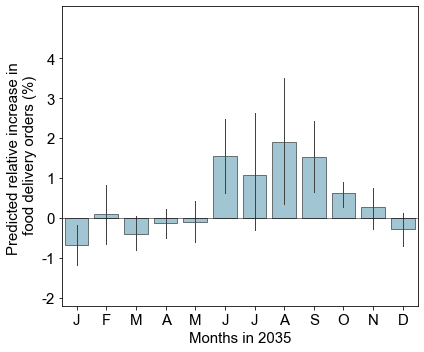

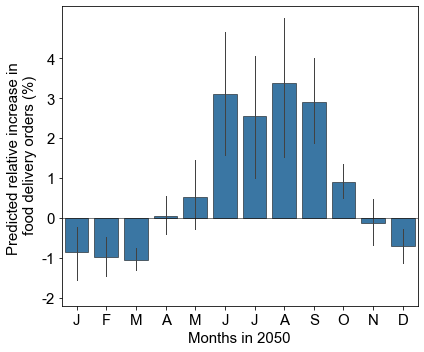

In [19]:
plt.figure(figsize = (6, 5))
sns.barplot(data = v35, x = 'month', y = 'relative_change', color = colors[1], edgecolor='black', linewidth = 0.5, err_kws={'linewidth': 1})
plt.xlabel('Months in 2035', size = 15)
plt.xticks(range(12), ['J','F','M','A','M','J','J','A','S','O','N','D'], size = 15)
plt.ylabel('Predicted relative increase in \n food delivery orders (%)', size = 15)
plt.yticks([-0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04], [-2,-1,0,1,2,3, 4], size = 15)
plt.ylim(-0.022, 0.053)
plt.hlines(0, -0.5, 11.5, lw = 0.5, color = 'black')
plt.xlim(-0.5, 11.5)
plt.tight_layout()
plt.show()

plt.figure(figsize = (6, 5))
sns.barplot(data = v50, x = 'month', y = 'relative_change', color = colors[0], edgecolor='black', linewidth = 0.5, err_kws={'linewidth': 1})
plt.xlabel('Months in 2050', size = 15)
plt.xticks(range(12), ['J','F','M','A','M','J','J','A','S','O','N','D'], size = 15)
plt.ylabel('Predicted relative increase in \n food delivery orders (%)', size = 15)
plt.yticks([-0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04], [-2,-1,0,1,2,3, 4], size = 15)
plt.ylim(-0.022, 0.053)
plt.hlines(0, -0.5, 11.5, lw = 0.5, color = 'black')
plt.xlim(-0.5, 11.5)
plt.tight_layout()
plt.show()

## Fig. S9

In [20]:
china_map = gpd.read_file('Data/maps/2023年地级/地级.shp')
china_province_map = gpd.read_file('Data/maps/2023年省级/省级.shp')
jiuduanxian = gpd.read_file('Data/maps/九段线/九段线.shp')
guojie = gpd.read_file('Data/maps/国界/国家矢量.shp')

In [21]:
city_pred50 = pd.read_csv('Data/city_projected_increase_2050_summer.csv')

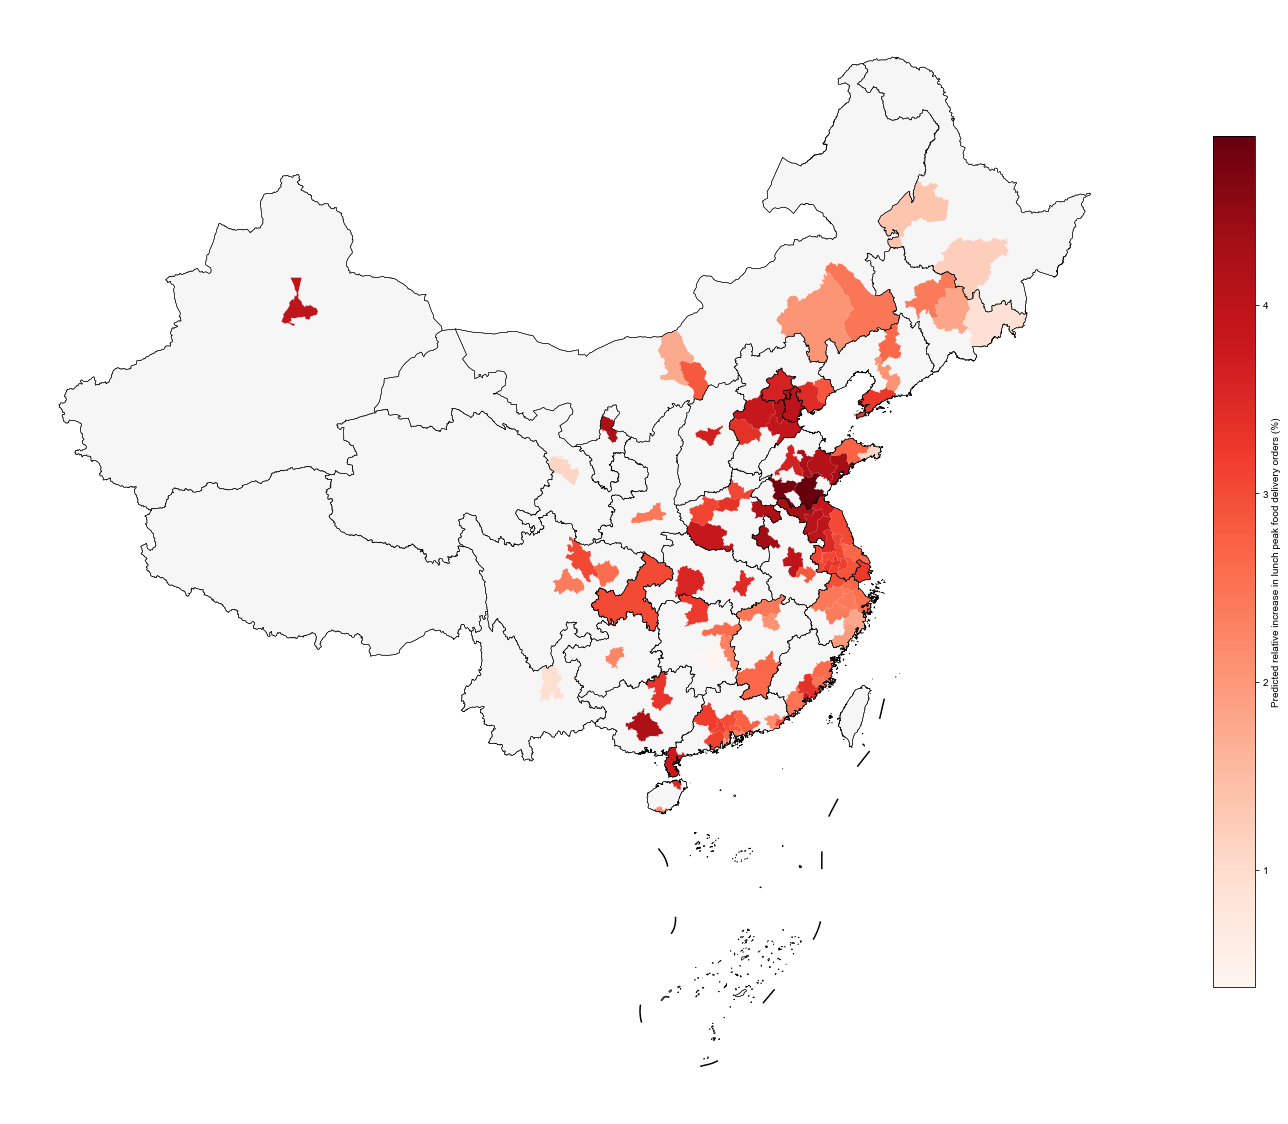

In [22]:
china_map50 = pd.merge(china_map, city_pred50, left_on = '地名', right_on = 'city_name', how = 'left')
fig, ax = plt.subplots(figsize = (20, 20))
china_map50.to_crs('EPSG:3857').plot(ax = ax, column = 'relative_change', legend=True, cmap = 'Reds',
   legend_kwds={"location":"right","shrink":.6,'label':'Predicted relative increase in lunch peak food delivery orders (%)'},
            missing_kwds = {'color': 'lightgrey', 'alpha': 0.2})
jiuduanxian.to_crs('EPSG:3857').plot(ax = ax, color = 'black')
guojie.boundary.to_crs('EPSG:3857').plot(ax = ax, color = 'black', lw = 0.5)
china_province_map.boundary.to_crs('EPSG:3857').plot(ax = ax, color = 'black', lw = 0.5)
ax.axis('off')
plt.tight_layout()
plt.show()